# Problem Set 2
## Javier Palomares
### Problem 1: Starting in Kaggle.
On February 27th, we are opening a Kaggle competition made for this class. In that one, you will
be participating on your own. This is an intro to get us started, and also an excuse to work with
regularization and regression which we have been discussing. Thus, even though this problem set
is not due until March 11, it would be a great idea to get experience on Kaggle before we start the
Kaggle competition on February 27th.

#### Question 2   
Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models. Then run a ridge regression using $\alpha = 0.1$. Make a submission of this prediction, what is the RMSE you get?
(Hint: remember to exponentiate np.expm1(ypred) your predictions).


##### Preprocessing

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Data preprocessing:
We're not going to do anything fancy here:

* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b59160>,
      dtype=object)

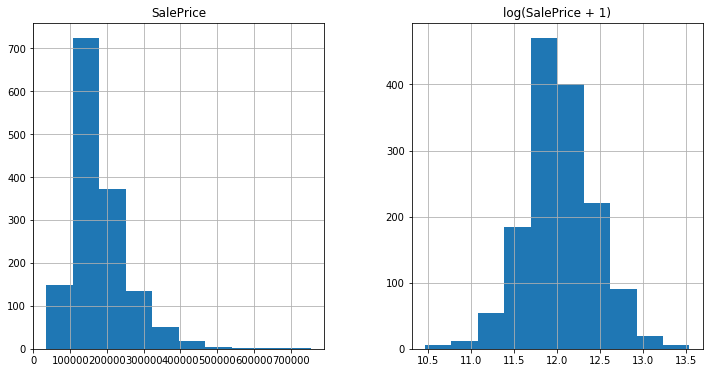

In [88]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"SalePrice":train["SalePrice"], "log(SalePrice + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [89]:
# log transform the sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

# get the numberical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# compute the skeweness factor of features
# take features with factor greater than .75
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# take the log of all skewed features
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [90]:
# Convert categorical variable into dummy/indicator variables
all_data = pd.get_dummies(all_data)

In [91]:
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [92]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

##### Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [93]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso,LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [94]:
# function to compute the root mean squared error of the cross validation
def rmse_cv(model,X_train,y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


We'll run a ridge regression using a value of $\alpha=0.1$

In [95]:
alpha = .1
ridge_model = Ridge(alpha=alpha)

In [96]:
cv_rmse_ridge = rmse_cv(ridge_model,X_train,y).mean()
print("Cross validation rmse using Ridge Regression = {}".format(cv_rmse_ridge))

Cross validation rmse using Ridge Regression = 0.13777538277187823


The ridge model gives a cross validation rmse of .1377 when $\alpha=.1$

In [97]:
# fit the model then get the y predicted
ridge_model.fit(X_train,y)
y_pred = ridge_model.predict(X_train)
# we took a log of the sale price in the pre processing, so we need to exponentiate y_pred and y to get the true sale prices
y_pred_exp = np.expm1(y_pred)
y_exp = np.expm1(y)

In [98]:
def rms(predicted,target):
    return np.sqrt(np.mean((predicted-target)**2))

In [99]:
rmse_ridge = rms(y_pred_exp,y_exp)
print("using alpha = 0.1, Ridge regression had an rmse of {}".format(rmse_ridge))

using alpha = 0.1, Ridge regression had an rmse of 17965.974938885953


The ridge model gives a  rmse in the Sale price of approximately 17965.97  when $\alpha=.1$

#### Question 3
Compare a ridge regression and a lasso regression model. Optimize the alphas using cross
validation. What is the best score you can get from a single ridge regression model and from
a single lasso model?

##### Ridge regresion

In [100]:
n_alphas = 200
alphas = np.logspace(-5, 3, n_alphas).tolist()
cv_ridge_rmse = [rmse_cv(Ridge(alpha = alpha),X_train,y).mean() 
            for alpha in alphas]

Text(0,0.5,'RMSE')

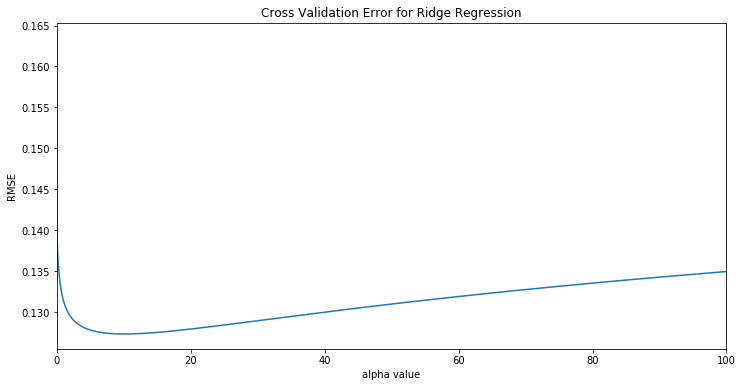

In [101]:
cv_ridge_rmse = pd.Series(cv_ridge_rmse, index = alphas)
cv_ridge_rmse.plot(title = "Cross Validation Error for Ridge Regression")
plt.xlabel("alpha value")
plt.xlim(0,100)
plt.ylabel("RMSE")

In [102]:
min_rmse_ridge = cv_ridge_rmse.min()
best_alpha_ridge = cv_ridge_rmse[cv_ridge_rmse==min_rmse_ridge].index[0]
print("The lowest cross validation RMSE for Ridge Regression is {} when alpha={}".format(min_rmse_ridge,best_alpha_ridge))

The lowest cross validation RMSE for Ridge Regression is 0.1273384731920464 when alpha=9.771241535346501


##### Lasso regression

(-0.5, 0.5)

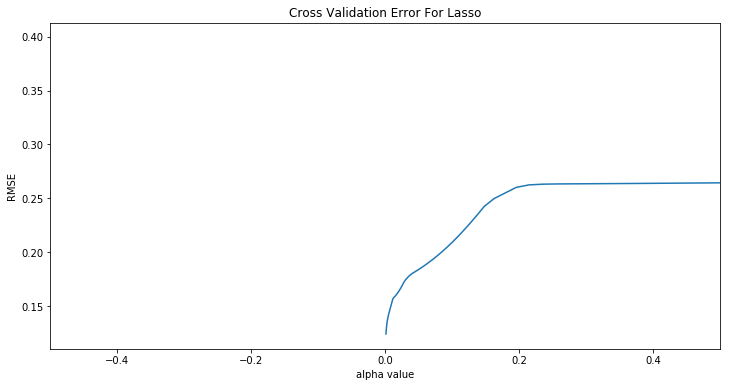

In [103]:
# the alphas in lasso are inverted from ridge
inv_alphas = np.ones(len(alphas)) /np.array(alphas)
cv_lasso_rmse = [rmse_cv(Lasso(alpha = alpha),X_train,y).mean() 
            for alpha in inv_alphas]
cv_lasso_rmse = pd.Series(cv_lasso_rmse, index = inv_alphas)
cv_lasso_rmse.plot(title = "Cross Validation Error For Lasso")
plt.xlabel("alpha value")
plt.ylabel("RMSE")
plt.xlim(-.5,.5)

In [104]:
min_rmse_lasso = cv_lasso_rmse.min()
best_alpha_lasso = cv_lasso_rmse[cv_lasso_rmse==min_rmse_lasso].index[0]
print("The lowest cross validation RMSE for Ridge Regression is {} when alpha={}".format(min_rmse_lasso,best_alpha_lasso))

The lowest cross validation RMSE for Ridge Regression is 0.12419498942266956 when alpha=0.001


In [105]:
# Create predictions with the best alpha scores for lasso and ridge
best_ridge = Ridge(alpha=best_alpha_ridge).fit(X_train,y)
best_lasso = Lasso(alpha=best_alpha_lasso).fit(X_train,y)

In [115]:
# exponentiate the prediction since we took the log of the sale price in the training data
y_pred_ridge = np.expm1(best_ridge.predict(X_test))
y_pred_lasso = np.expm1(best_lasso.predict(X_test))
ids = test['Id']

In [328]:
def print_predictions(filename,header,ids,y_pred):
    f = open(filename,'w')
    numRows = len(ids)
    f.write(header)
    for i in range(numRows):
        idNum = ids[i]
        y = y_pred[i]
        f.write("{},{}\n".format(idNum,y))
    f.close()

In [329]:
print_predictions("ridge_prediction.csv",'Id,SalePrice\n',ids,y_pred_ridge)
print_predictions("lasso_prediction.csv",'Id,SalePrice\n',ids,y_pred_lasso)

My lasso submission scored 0.12238.  
My ridge regression scored 0.12225.

#### Question 4
Plot the $l_0$ norm (number of nonzeros) of the coefficients that lasso produces as you vary the
strength of regularization parameter alpha.

In [107]:
l0_norm = np.zeros(len(inv_alphas))
for i in range(len(inv_alphas)):
    alpha = inv_alphas[i]
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train,y)
    coeff = lasso_model.coef_
    num_nzero_coeff = sum(coeff != 0)
    l0_norm[i] = num_nzero_coeff


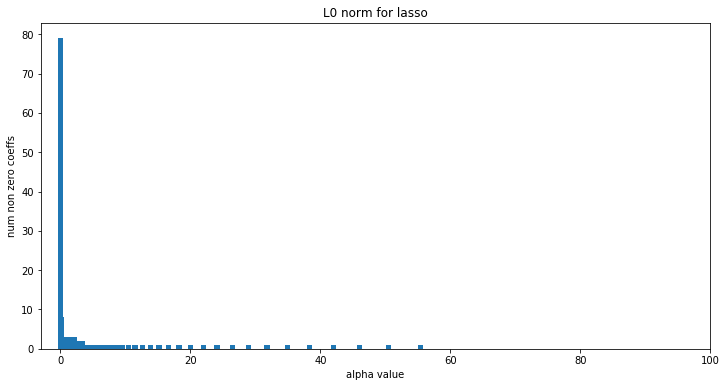

In [108]:
plt.bar(inv_alphas,l0_norm)
plt.xlim(-3,100)
plt.title("L0 norm for lasso")
plt.xlabel('alpha value')
plt.ylabel('num non zero coeffs')
plt.show()

#### Question 5
Add the outputs of your models as features and train a ridge regression on all the features
plus the model outputs. This is called Ensembling and Stacking, which we discussed in class.
Be careful not to overfit. What score can you get?

In [109]:
ridge_model_output = best_ridge.predict(X_train).tolist()
lasso_model_output = best_lasso.predict(X_train).tolist()

In [110]:
# add the output of the ridge and lasso models as features of X_train
X_train['ridge_pred'] = ridge_model_output
X_train['lasso_pred'] = lasso_model_output

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0,0.5,'RMSE')

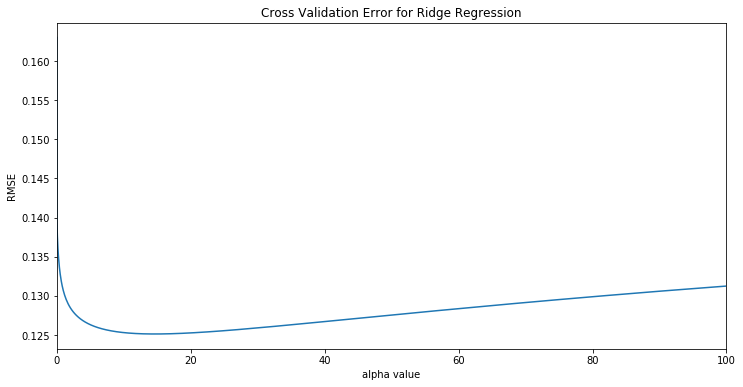

In [112]:
# now train a ridge regression with the new features
n_alphas = 200
alphas = np.logspace(-5, 3, n_alphas).tolist()
# Now retrain a ridge regression.
cv_ridge_stacking = [rmse_cv(Ridge(alpha = alpha),X_train,y).mean() 
            for alpha in alphas]
cv_ridge_stacking = pd.Series(cv_ridge_stacking, index = alphas)
cv_ridge_stacking.plot(title = "Cross Validation Error for Ridge Regression")
plt.xlabel("alpha value")
plt.xlim(0,100)
plt.ylabel("RMSE")

In [122]:
min_rmse_ridge_stacking = cv_ridge_stacking.min()
best_alpha_ridge_stacking = cv_ridge_stacking[cv_ridge_stacking==min_rmse_ridge_stacking].index[0]
print("The lowest cross validation RMSE after stacking for Ridge Regression is {} when alpha={}".format(min_rmse_ridge_stacking,best_alpha_ridge_stacking))

The lowest cross validation RMSE after stacking for Ridge Regression is 0.1251338331369107 when alpha=14.149912974345758


In [125]:
best_ridge_stacking = Ridge(alpha=best_alpha_ridge_stacking).fit(X_train,y)

In [118]:
# Add the predictions from ridge and lasso to the test data as well
y_pred_ridge = best_ridge.predict(X_test).tolist()
y_pred_lasso = best_lasso.predict(X_test).tolist()
X_test['ridge_pred'] = y_pred_ridge
X_test['lasso_pred'] = y_pred_lasso


/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [126]:
y_pred_stacking = best_ridge_stacking.predict(X_test)
print_predictions("stacking_prediction.csv",'Id,SalePrice\n',ids,y_pred_stacking)

I did not see an improvement in the score after stacking

#### Question 6
Install XGBoost and train a gradient descent boost regression. What score can you get from a single XGB?

In [6]:
import xgboost
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split


Remove the stacking columns from the data for now

In [9]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data = pd.get_dummies(all_data)
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

##### Optimizing XGBoost hyperparameters

In [ ]:
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]
}

xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch.fit(X_train,y)
print (gsearch1.cv_results_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)


Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


/home/jpalomares/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   52.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 10

# TODO: Finish the rest of problem 1

### Problem 2: Starting with Neural Nets and Fast.ai.
The goal of the next part of this problem set is to get us up and running with some modern tools
for playing with Neural Networks. Specifically, we will be exploring a very powerful library built
on top of PyTorch, called Fast.ai. This problem set and the next one will require access to a GPU.
While Fast.ai is all open source and in principle you can download and install anywhere, doing this
successfully may require considerable effort. Therefore, we highly recommend that you use a cloud
computing service that already has Fast.ai set up. There are many options. We recommend either
colab (free), or paperspace (not free, but not too expensive – I’ve been using a machine that
costs $0.78/hour). There are other options as well.

### Question 1
Paperspace. As an example... if you want to use Paperspace, then: create an account on
paperspace or a cloud service of your choice. You should make sure that you are able to install
all the libraries and tools needed for Fast.ai. If you choose to do this on paperspace.com,
then:
* Create an account on paperspace.
* Log in.
* Go to Gradient in the toolbar in the left.
* Create Notebook.
* Paperspace Fast.AI 1.0 (V3).
* Choose the P5000 machine ($0.78/hour).
* Launch, and go to: course-v3 −→ nbs −→ dl1 and open up the first lesson: lesson1-
pets.ipynb.

#### Question 2
Fast.ai has created a huge library of tools that make setting up and training a neural network
very easy, especially through the use of transfer learning. The notebook you opened in the
previous exercise corresponds to the first lesson under “Practical Deep Learning for Coders.”
Watch this lesson, and follow along on the notebook.

### Question 3
Make sure you understand the key elements of using Fast.ai, including understanding how to
access the help documentation. Specifically:
* Figure out: ImageDataBunch: this is the main data structure that is used.
* Figure out: create cnn. This is the way you will create a “learner” that you will then
train for some number of epochs. The key here is how easy it is to download a pre-set
architecture (e.g., the notebook starts with resnet34, but has various others as well).

### Question 4
Explain what is a residual network, and the basic motivation for using it. Also
explain what are the main elements of resnet34 and resnet50. How many layers, how many
neurons total, how many weights; and then anything else you want to say.

# TODO: Answer

### Question 5
(Optional) Transfer learning using Fast.ai and create cnn: Please explain how pretrained
resnet34 is modified to get the network that the notebook ultimately trains (i.e., explain
what are the last layers that are added).

# TODO: Answer